In [25]:
import numpy as np
import matplotlib.pyplot as plt

from collections import *

<br>

# Simulation
---

Check what you observe with the delay between what happens and observations:

* give a $R_O$ curve
* show what you observe



Total contaminated: 63033851
Total deaths: 1249362


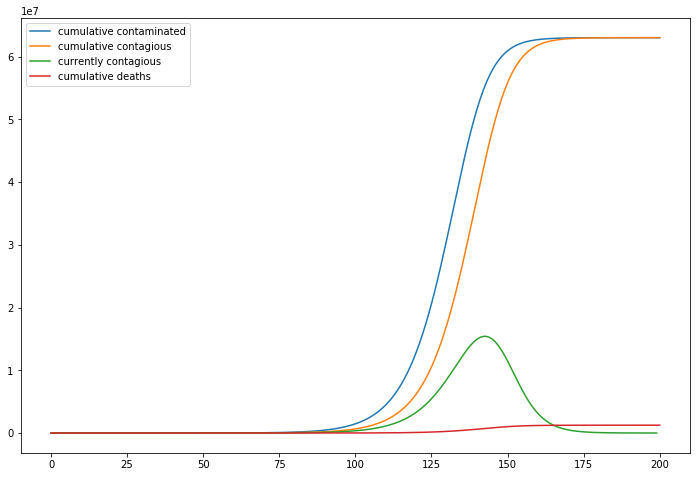

In [61]:
def simulate(r_0: float,
             death_rate: float,
             incubation_duration: int,
             disease_duration: int,
             population: int,
             initial_infected: int,
             nb_turns: int):
    
    total_contaminated = [initial_infected]
    total_contagious = [initial_infected]
    total_deaths = [0]
    currently_contagious = []
    
    incubating_phase = deque([0] * incubation_duration)
    contagious_phase = deque([0] * (disease_duration-1) + [disease_duration]) 
    
    daily_death_rate = death_rate / disease_duration
    
    for turn in range(nb_turns):
        contagious = sum(contagious_phase)
        currently_contagious.append(contagious)
        contagious_phase.append(incubating_phase.popleft())
        total_contagious.append(total_contagious[-1] + contagious_phase[-1])
        contagious_phase.popleft()
        
        vulnerable = population - total_contaminated[-1]
        percentage_vulnerable = vulnerable / population
        effective_r_0 = (r_0 / disease_duration) * percentage_vulnerable
        new_infected = min(vulnerable, contagious * effective_r_0)
        
        today_deaths = 0
        for i, count in enumerate(contagious_phase):
            deaths = int(daily_death_rate * count)
            contagious_phase[i] -= deaths
            today_deaths += deaths
        total_deaths.append(total_deaths[-1] + today_deaths)
        
        incubating_phase.append(new_infected)
        total_contaminated.append(total_contaminated[-1] + int(new_infected))

    print("Total contaminated:", total_contaminated[-1])
    print("Total deaths:", total_deaths[-1])
    return {'total_contaminated': total_contaminated,
            'total_contagious': total_contagious,
            'total_deaths': total_deaths,
            'currently_contagious': currently_contagious}


results = simulate(r_0=3.5, death_rate=0.02,
                   disease_duration=7, incubation_duration=7,
                   population=65_000_000, initial_infected=1, nb_turns=200)

plt.figure(figsize=(12,8))
plt.plot(results['total_contaminated'], label='cumulative contaminated')
plt.plot(results['total_contagious'], label='cumulative contagious')
plt.plot(results['currently_contagious'], label='currently contagious')
plt.plot(results['total_deaths'], label='cumulative deaths')
plt.legend()
plt.show()